# TCGA Epistatic Double Variants: One-Sided Correlation in Prognostic Genes

Find double variants with **asymmetric co-occurrence** — one variant (the "dependent")
almost always appears with the other (the "anchor"), even though the anchor is
frequently seen alone. This pattern is the hallmark of epistasis: the dependent
variant is only selected for / tolerated in the presence of the anchor.

**Filters:**
1. Both variants in known **cancer genes** (OncoKB)
2. At least one gene has **prognostic significance** (Human Protein Atlas)
3. Within **500bp** of each other
4. **3–50 patients** carry both (true epistasis is rare)
5. **One-sided conditional probability ≥ 0.80** — the dependent variant co-occurs
   with the anchor in ≥80% of cases

Uses ParseTCGA for TCGA parquet + clinical data.

In [1]:
import sys
from pathlib import Path

PARSETCGA_ROOT = Path("/tamir2/nicolaslynn/tools/ParseTCGA")
if PARSETCGA_ROOT.exists():
    sys.path.insert(0, str(PARSETCGA_ROOT))

import numpy as np
import pandas as pd
import duckdb
from tqdm import tqdm

from parsetcga import TCGAData
from parsetcga.ids import epistasis_id as make_epistasis_id

tcga = TCGAData(data_dir='/tamir2/nicolaslynn/data/tcga_aggregate')
parquet_path = tcga._mutations_path
print("Parquet:", parquet_path)

# Paper data root for saving outputs
ROOT = Path.cwd()
for _ in range(4):
    if (ROOT / "notebooks" / "paper_data_config.py").exists():
        break
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
from notebooks.paper_data_config import data_dir




Parquet: /Users/nicolaslynn/Documents/phd/ParseTCGA/data/tcga_all.parquet


## Step 1. CONFIG

- **MAX_DIST_BP = 500** — variant proximity window
- **MIN_COND_PROB = 0.80** — the dependent variant must co-occur with the anchor
  in ≥80% of the cases where it appears
- **MAX_CASES_BOTH = 50** — pairs in >50 patients are likely passengers
- **MIN_CASES_BOTH = 3** — minimum for any statistical power

In [71]:
MAX_DIST_BP = 100
MIN_DEPTH   = 15
ALT_MIN     = 15
MIN_VAF     = 0.10

# One-sided correlation threshold
MIN_COND_PROB = 0.80  # dependent variant co-occurs with anchor >= this fraction

# Patient-count limits per double variant
MAX_CASES_BOTH = 50
MIN_CASES_BOTH = 3

# Gene filters
CANCER_GENES_ONLY = False
EXCLUDE_TOP_BURDEN_GENES = 20

# Prognostic data (Human Protein Atlas)
PROGNOSTIC_P_THRESHOLD = 0.05
PROGNOSTIC_DATA_PATH = Path(
    "/Users/nicolaslynn/Documents/phd/projects/genomenet/"
    "manuscript_figures/cancer_prognostic_data.tsv"
)



## Step 2. Load cancer genes + prognostic genes

In [72]:
# --- Cancer genes (OncoKB) ---
for base in [Path(".."), Path("../.."), Path(".")]:
    cancer_tsv = base / "cancerGeneList.tsv"
    if cancer_tsv.exists():
        break
else:
    raise FileNotFoundError("cancerGeneList.tsv not found")

cg = pd.read_csv(cancer_tsv, sep="\t")
cancer_genes = set(cg["Hugo Symbol"].dropna().astype(str).str.strip())
print(f"Cancer genes: {len(cancer_genes)}")

# --- Prognostic genes (HPA) ---
prog_raw = pd.read_csv(PROGNOSTIC_DATA_PATH, sep="\t")
unfav_cols = ["potential prognostic - unfavorable", "validated prognostic - unfavorable"]
fav_cols  = ["potential prognostic - favorable",   "validated prognostic - favorable"]
prog_raw["best_unfav_p"] = prog_raw[unfav_cols].min(axis=1)
prog_raw["best_fav_p"]   = prog_raw[fav_cols].min(axis=1)
prog_raw["cancer_base"] = (
    prog_raw["Cancer"]
    .str.replace(" (TCGA)", "", regex=False)
    .str.replace(" (validation)", "", regex=False)
)

prog_sig = prog_raw[
    (prog_raw["best_unfav_p"] < PROGNOSTIC_P_THRESHOLD)
    | (prog_raw["best_fav_p"] < PROGNOSTIC_P_THRESHOLD)
]
prognostic_genes = set(prog_sig["Gene name"].dropna().astype(str).str.strip())
cancer_prognostic = prognostic_genes
print(f"Prognostic genes (HPA p<{PROGNOSTIC_P_THRESHOLD}): {len(prognostic_genes)}")
print(f"Cancer genes with prognostic signal: {len(cancer_prognostic)}")

# Project → HPA cancer name mapping
PROJ_TO_CANCER = {
    "BLCA": "Bladder Urothelial Carcinoma",
    "BRCA": "Breast Invasive Carcinoma",
    "CESC": "Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma",
    "COAD": "Colon Adenocarcinoma",
    "GBM":  "Glioblastoma Multiforme",
    "HNSC": "Head and Neck Squamous Cell Carcinoma",
    "KICH": "Kidney Chromophobe",
    "KIRC": "Kidney Renal Clear Cell Carcinoma",
    "KIRP": "Kidney Renal Papillary Cell Carcinoma",
    "LIHC": "Liver Hepatocellular Carcinoma",
    "LUAD": "Lung Adenocarcinoma",
    "LUSC": "Lung Squamous Cell Carcinoma",
    "OV":   "Ovary Serous Cystadenocarcinoma",
    "PAAD": "Pancreatic Adenocarcinoma",
    "PRAD": "Prostate Adenocarcinoma",
    "READ": "Rectum Adenocarcinoma",
    "SKCM": "Skin Cutaneous Melanoma",
    "STAD": "Stomach Adenocarcinoma",
    "TGCT": "Testicular Germ Cell Tumor",
    "THCA": "Thyroid Carcinoma",
    "UCEC": "Uterine Corpus Endometrial Carcinoma"
}

prog_lookup = {}
for _, r in prog_raw.iterrows():
    key = (str(r["Gene name"]).strip(), str(r["cancer_base"]).strip())
    prog_lookup[key] = (r["best_unfav_p"], r["best_fav_p"])
print(f"Prognostic lookup: {len(prog_lookup)} (gene, cancer) entries")



Cancer genes: 1221
Prognostic genes (HPA p<0.05): 14033
Cancer genes with prognostic signal: 14033
Prognostic lookup: 419244 (gene, cancer) entries


## Step 3. Load mutations

Query TCGA parquet for mutations passing depth/alt quality filters.
Restrict to cancer genes and exclude top burden genes (TTN, MUC6, etc.).

In [73]:
con = duckdb.connect()
q = """
SELECT
    case_id, Gene_name, Chromosome, Start_Position,
    (Gene_name || ':' || REPLACE(Chromosome, 'chr', '') || ':'
     || CAST(Start_Position AS VARCHAR) || ':'
     || UPPER(COALESCE(Reference_Allele, '')) || ':'
     || UPPER(COALESCE(Tumor_Seq_Allele2, ''))) AS mutation_id,
    t_depth, t_alt_count
FROM read_parquet(?)
WHERE t_depth >= ? AND COALESCE(t_alt_count, 0) >= ?
"""
raw = con.execute(q, [str(parquet_path), MIN_DEPTH, ALT_MIN]).fetchdf()
con.close()

raw["pos"] = raw["Start_Position"].astype(int)
raw["vaf"] = (raw["t_alt_count"] / raw["t_depth"].clip(lower=1)).astype(float)
raw["chrom"] = raw["Chromosome"].astype(str).str.replace("chr", "", regex=False)

print(f"Total mutations (depth>={MIN_DEPTH}, alt>={ALT_MIN}): {len(raw):,}")

if CANCER_GENES_ONLY:
    raw = raw[raw["Gene_name"].astype(str).str.strip().isin(cancer_genes)].copy()
    print(f"After cancer-gene filter: {len(raw):,} rows, {raw['case_id'].nunique():,} cases")

if EXCLUDE_TOP_BURDEN_GENES > 0:
    gene_cts = raw["Gene_name"].value_counts()
    excluded = set(gene_cts.head(EXCLUDE_TOP_BURDEN_GENES).index)
    raw = raw[~raw["Gene_name"].isin(excluded)].copy()
    print(f"Excluded top {EXCLUDE_TOP_BURDEN_GENES} burden genes: {', '.join(sorted(excluded)[:5])}...")
    print(f"Remaining: {len(raw):,} rows")


    

Total mutations (depth>=15, alt>=15): 10,815,708
Excluded top 20 burden genes: AHNAK2, FLG, FRG2C, GAGE1, HLA-DRB1...
Remaining: 9,853,783 rows


In [74]:
excluded

{'AHNAK2',
 'FLG',
 'FRG2C',
 'GAGE1',
 'HLA-DRB1',
 'HRNR',
 'KIR2DL1',
 'KIR2DL3',
 'KIR2DL4',
 'KIR3DL1',
 'KIR3DL2',
 'KMT2C',
 'MUC16',
 'MUC6',
 'NBPF1',
 'OR8U1',
 'PRSS1',
 'PRSS3',
 'TAS2R31',
 'TTN'}

## Step 4. Find candidate pairs

Same case, same chromosome, within 500bp, both VAF ≥ 10%, both in cancer genes,
at least one gene prognostically significant.

In [75]:
pairs = []
for (case_id, chrom), grp in tqdm(
    raw.groupby(["case_id", "chrom"]), desc="Finding pairs"
):
    grp = grp.sort_values("pos").reset_index(drop=True)
    if len(grp) < 2:
        continue

    pos     = grp["pos"].values
    vafs    = grp["vaf"].values
    genes   = grp["Gene_name"].values
    mut_ids = grp["mutation_id"].values

    for i in range(len(grp)):
        hi = np.searchsorted(pos, pos[i] + MAX_DIST_BP, side="right")
        for j in range(i + 1, hi):
            if pos[j] - pos[i] <= 0:
                continue
            if vafs[i] < MIN_VAF or vafs[j] < MIN_VAF:
                continue
            g_i = str(genes[i]).strip()
            g_j = str(genes[j]).strip()
            # if g_i not in prognostic_genes and g_j not in prognostic_genes:
            #     continue

            pairs.append({
                "case_id": case_id,
                "epistasis_id": make_epistasis_id([mut_ids[i], mut_ids[j]]),
                "mut1_id": mut_ids[i],
                "mut2_id": mut_ids[j],
                "gene1": g_i,
                "gene2": g_j,
                "distance_bp": int(pos[j] - pos[i]),
            })

pairs_df = pd.DataFrame(pairs)
if pairs_df.empty:
    raise RuntimeError("No pairs found. Relax filters.")
pairs_df = pairs_df.drop_duplicates(subset=["epistasis_id", "case_id"])
print(f"Candidate pairs: {len(pairs_df):,} case-epistasis, "
      f"{pairs_df['epistasis_id'].nunique():,} unique")




Finding pairs: 100%|██████████████████| 344007/344007 [00:39<00:00, 8803.57it/s]


Candidate pairs: 391,165 case-epistasis, 203,104 unique


## Step 5. Epistasis summary + one-sided correlation filter

For each pair, compute global co-occurrence counts and **conditional probabilities**:

- `P(mut1|mut2)` = n_both / (n_both + n_only_mut2) — "if you have mut2, do you also have mut1?"
- `P(mut2|mut1)` = n_both / (n_both + n_only_mut1) — "if you have mut1, do you also have mut2?"

The **dependent** variant is the one with the higher conditional probability — it almost
never appears without the **anchor**. The anchor can appear frequently on its own.

Filter for `max(P(mut1|mut2), P(mut2|mut1)) >= MIN_COND_PROB`.

In [76]:
lookup_path = tcga.mutations.build_mutation_lookup()

epi_info = pairs_df.groupby("epistasis_id", as_index=False).agg(
    mut1_id=("mut1_id", "first"),
    mut2_id=("mut2_id", "first"),
    gene1=("gene1", "first"),
    gene2=("gene2", "first"),
    distance_bp=("distance_bp", "median"),
)

# Batch lookup: mutation_id → set(case_ids)
all_muts = list(set(epi_info["mut1_id"]) | set(epi_info["mut2_id"]))
con = duckdb.connect(str(lookup_path))
parts = []
for i in tqdm(range(0, len(all_muts), 50_000), desc="Loading lookup"):
    chunk = all_muts[i : i + 50_000]
    parts.append(
        con.execute(
            "SELECT mutation_id, case_id FROM mut_lookup "
            "WHERE mutation_id IN (SELECT unnest(?))",
            [chunk],
        ).fetchdf()
    )
con.close()
lookup_df = pd.concat(parts, ignore_index=True)
m2c = lookup_df.groupby("mutation_id")["case_id"].apply(
    lambda x: set(x.astype(str))
).to_dict()

rows = []
for _, r in tqdm(epi_info.iterrows(), total=len(epi_info), desc="Computing co-occurrence"):
    s1 = m2c.get(r["mut1_id"], set())
    s2 = m2c.get(r["mut2_id"], set())
    both   = s1 & s2
    only1  = s1 - s2
    only2  = s2 - s1
    nb, no1, no2 = len(both), len(only1), len(only2)

    n_mut1 = nb + no1
    n_mut2 = nb + no2
    p_mut1_given_mut2 = nb / max(n_mut2, 1)  # if you have mut2, how often mut1?
    p_mut2_given_mut1 = nb / max(n_mut1, 1)  # if you have mut1, how often mut2?

    cond_max = max(p_mut1_given_mut2, p_mut2_given_mut1)
    cond_min = min(p_mut1_given_mut2, p_mut2_given_mut1)

    # Label anchor vs dependent
    if p_mut1_given_mut2 >= p_mut2_given_mut1:
        # mut2 patients almost always have mut1 → mut2 is dependent, mut1 is anchor
        dep_mut, anc_mut = r["mut2_id"], r["mut1_id"]
        dep_gene, anc_gene = r["gene2"], r["gene1"]
    else:
        # mut1 patients almost always have mut2 → mut1 is dependent, mut2 is anchor
        dep_mut, anc_mut = r["mut1_id"], r["mut2_id"]
        dep_gene, anc_gene = r["gene1"], r["gene2"]

    rows.append({
        "epistasis_id": r["epistasis_id"],
        "anchor_mut": anc_mut,
        "dependent_mut": dep_mut,
        "anchor_gene": anc_gene,
        "dependent_gene": dep_gene,
        "distance_bp": int(r["distance_bp"]) if pd.notna(r["distance_bp"]) else None,
        "n_cases_both": nb,
        "n_only_anchor": no1 if anc_mut == r["mut1_id"] else no2,
        "n_only_dependent": no2 if dep_mut == r["mut2_id"] else no1,
        "n_anchor_total": n_mut1 if anc_mut == r["mut1_id"] else n_mut2,
        "n_dependent_total": n_mut2 if dep_mut == r["mut2_id"] else n_mut1,
        "cond_prob_dependent": cond_max,   # P(anchor | dependent)
        "cond_prob_anchor": cond_min,      # P(dependent | anchor)
        "case_ids_both": ",".join(sorted(both)) if both else "",
        "case_ids_only_mut1": ",".join(sorted(only1)) if only1 else "",
        "case_ids_only_mut2": ",".join(sorted(only2)) if only2 else "",
    })

epi_all = pd.DataFrame(rows)
print(f"Total unique pairs: {len(epi_all):,}")
print(f"\nConditional probability (dependent) distribution:")
print(epi_all["cond_prob_dependent"].describe().to_string())




Computing co-occurrence: 100%|███████| 203104/203104 [00:06<00:00, 31123.26it/s]


Total unique pairs: 203,104

Conditional probability (dependent) distribution:
count    203104.000000
mean          0.780955
std           0.316367
min           0.002976
25%           0.500000
50%           1.000000
75%           1.000000
max           1.000000


In [81]:
# Apply filters: patient cap + one-sided correlation
epi_df = epi_all[
    (epi_all["n_cases_both"] >= MIN_CASES_BOTH)
    & (epi_all["n_cases_both"] <= MAX_CASES_BOTH)
    & (epi_all["cond_prob_dependent"] >= MIN_COND_PROB)
].sort_values(
    ["cond_prob_dependent", "n_cases_both"], ascending=[False, False]
).reset_index(drop=True)

print(f"After filters ({MIN_CASES_BOTH}–{MAX_CASES_BOTH} patients, "
      f"cond_prob >= {MIN_COND_PROB}): {len(epi_df)} pairs")

if not epi_df.empty:
    print(f"\nn_cases_both: {epi_df['n_cases_both'].describe().to_string()}")
    print(f"\ncond_prob_dependent: {epi_df['cond_prob_dependent'].describe().to_string()}")
    print(f"\nAnchor genes: {epi_df['anchor_gene'].nunique()}")
    print(f"Dependent genes: {epi_df['dependent_gene'].nunique()}")
    print(f"\nTop anchor genes:")
    print(epi_df["anchor_gene"].value_counts().head(10).to_string())
    print(f"\nTop dependent genes:")
    print(epi_df["dependent_gene"].value_counts().head(10).to_string())
    display(epi_df.drop(columns=["case_ids_both", "case_ids_only_mut1", "case_ids_only_mut2"]).head(30))
else:
    print("No pairs passed filters. Try lowering MIN_COND_PROB or raising MAX_CASES_BOTH.")



After filters (3–50 patients, cond_prob >= 0.8): 10900 pairs

n_cases_both: count    10900.000000
mean        14.552018
std         11.796931
min          3.000000
25%          5.000000
50%         10.000000
75%         22.000000
max         50.000000

cond_prob_dependent: count    10900.000000
mean         0.930870
std          0.074033
min          0.800000
25%          0.860465
50%          0.954545
75%          1.000000
max          1.000000

Anchor genes: 4898
Dependent genes: 4898

Top anchor genes:
anchor_gene
HSPA1L      253
HLA-DQA1     84
HLA-DPB1     68
MUC4         65
HLA-DQB1     62
HLA-A        55
BOLA1        55
HLA-DRB5     55
HLA-C        48
MUC3A        45

Top dependent genes:
dependent_gene
HSPA1L      253
HLA-DQA1     84
HLA-DPB1     67
MUC4         65
HLA-DQB1     62
BOLA1        55
HLA-DRB5     55
HLA-A        55
HLA-C        48
MUC3A        45


,epistasis_id,anchor_mut,dependent_mut,anchor_gene,dependent_gene,distance_bp,n_cases_both,n_only_anchor,n_only_dependent,n_anchor_total,n_dependent_total,cond_prob_dependent,cond_prob_anchor
0,AK7:14:96405000:C:T|AK7:14:96405001:C:T,AK7:14:96405000:C:T,AK7:14:96405001:C:T,AK7,AK7,1,50,0,0,50,50,1.0,1.000000
1,PARP4:13:24443452:T:C|PARP4:13:24443453:C:T,PARP4:13:24443453:C:T,PARP4:13:24443452:T:C,PARP4,PARP4,1,50,1,0,51,50,1.0,0.980392
2,C6orf15:6:31111297:C:T|C6orf15:6:31111299:G:A,C6orf15:6:31111297:C:T,C6orf15:6:31111299:G:A,C6orf15,C6orf15,2,49,0,0,49,49,1.0,1.000000
3,FANCD2:3:10046759:C:A|FANCD2:3:10046760:A:G,FANCD2:3:10046759:C:A,FANCD2:3:10046760:A:G,FANCD2,FANCD2,1,49,1,0,50,49,1.0,0.980000
4,GCC2:2:108450881:C:-|GCC2:2:108450882:A:T,GCC2:2:108450881:C:-,GCC2:2:108450882:A:T,GCC2,GCC2,1,49,4,0,53,49,1.0,0.924528
5,GRAMD4:22:46673033:G:-|GRAMD4:22:46673038:G:T,GRAMD4:22:46673033:G:-,GRAMD4:22:46673038:G:T,GRAMD4,GRAMD4,5,49,3,0,52,49,1.0,0.942308
6,MCC:5:113049307:C:G|MCC:5:113049308:A:C,MCC:5:113049307:C:G,MCC:5:113049308:A:C,MCC,MCC,1,49,0,0,49,49,1.0,1.000000
7,SETD2:3:47039701:-:CT|SETD2:3:47039704:GA:-,SETD2:3:47039701:-:CT,SETD2:3:47039704:GA:-,SETD2,SETD2,3,49,0,0,49,49,1.0,1.000000
8,TCP11L1:11:33075790:G:A|TCP11L1:11:33075793:C:G,TCP11L1:11:33075793:C:G,TCP11L1:11:33075790:G:A,TCP11L1,TCP11L1,3,49,2,0,51,49,1.0,0.960784
9,ABCA13:7:48483248:C:G|ABCA13:7:48483249:A:G,ABCA13:7:48483248:C:G,ABCA13:7:48483249:A:G,ABCA13,ABCA13,1,48,0,0,48,48,1.0,1.000000


## Step 6. Per-cancer survival (burden-matched + prognostic annotation)

For each pair in each cancer type:
1. Restrict to patients with ≤3 mutations in the gene(s) (burden-matched)
2. Log-rank: double vs single
3. Attach HPA prognostic p-values for that gene×cancer
4. FDR correction across all tests

In [27]:
from lifelines.statistics import logrank_test
from scipy.stats import false_discovery_control

clin = tcga.clinical.survival_prepared()
clin["case_id"] = clin["case_id"].astype(str)

proj_cases = {}
for proj in clin["Proj_name"].dropna().unique():
    proj_cases[proj] = set(clin.loc[clin["Proj_name"] == proj, "case_id"])

MIN_PER_GROUP = 5
surv_rows = []

for _, row in tqdm(epi_df.iterrows(), total=len(epi_df), desc="Survival"):
    epi_id = row["epistasis_id"]
    both = set(x.strip() for x in (row["case_ids_both"] or "").split(",") if x.strip())
    o1 = set(x.strip() for x in (row["case_ids_only_mut1"] or "").split(",") if x.strip())
    o2 = set(x.strip() for x in (row["case_ids_only_mut2"] or "").split(",") if x.strip())
    single = o1 | o2
    genes = list(set(p.split(":")[0] for p in epi_id.split("|") if ":" in p))
    if not genes:
        continue

    all_cases = list(both | single)
    try:
        con = duckdb.connect()
        burden = con.execute(
            "SELECT case_id, COUNT(*) AS n "
            "FROM read_parquet(?) "
            "WHERE Gene_name IN (SELECT unnest(?)) "
            "AND case_id IN (SELECT unnest(?)) "
            "GROUP BY case_id",
            [str(parquet_path), genes, all_cases],
        ).fetchdf()
        con.close()
        burden = burden.set_index("case_id")["n"]
    except Exception:
        continue

    exact2 = set(burden[burden <= 3].index.astype(str))
    both2 = both & exact2
    single2 = single & exact2

    for proj, pcases in proj_cases.items():
        b_p = both2 & pcases
        s_p = single2 & pcases
        if len(b_p) < MIN_PER_GROUP or len(s_p) < MIN_PER_GROUP:
            continue

        sub = clin[clin["case_id"].isin(b_p | s_p)].copy()
        sub["group"] = sub["case_id"].map(lambda c: 1 if c in b_p else 0)
        g1 = sub[sub["group"] == 1]
        g0 = sub[sub["group"] == 0]

        try:
            pv = logrank_test(
                g1["duration"], g0["duration"],
                event_observed_A=g1["event"],
                event_observed_B=g0["event"],
            ).p_value
        except Exception:
            continue

        cancer_name = PROJ_TO_CANCER.get(proj)
        prog_unfav, prog_fav = np.nan, np.nan
        if cancer_name:
            for g in genes:
                u, f = prog_lookup.get((g, cancer_name), (np.nan, np.nan))
                if not np.isnan(u):
                    prog_unfav = np.nanmin([prog_unfav, u]) if not np.isnan(prog_unfav) else u
                if not np.isnan(f):
                    prog_fav = np.nanmin([prog_fav, f]) if not np.isnan(prog_fav) else f

        surv_rows.append({
            "epistasis_id": epi_id,
            "anchor_gene": row["anchor_gene"],
            "dependent_gene": row["dependent_gene"],
            "cond_prob_dep": row["cond_prob_dependent"],
            "project": proj,
            "n_double": len(b_p),
            "n_single": len(s_p),
            "p_value": pv,
            "median_surv_double": g1["duration"].median(),
            "median_surv_single": g0["duration"].median(),
            "double_worse": g1["duration"].median() < g0["duration"].median(),
            "prog_unfav_p": prog_unfav,
            "prog_fav_p": prog_fav,
        })



Survival: 100%|█████████████████████████████| 7468/7468 [38:27<00:00,  3.24it/s]


In [29]:
surv_df = pd.DataFrame(surv_rows)

if not surv_df.empty:
    n = len(surv_df)
    surv_df["p_fdr"]  = false_discovery_control(surv_df["p_value"].values)
    surv_df["p_bonf"] = np.minimum(surv_df["p_value"].values * n, 1.0)
    surv_df["sig_fdr"] = surv_df["p_fdr"] < 0.05

    sig_worse = surv_df[surv_df["sig_fdr"] & surv_df["double_worse"]]
    raw_sig   = surv_df[surv_df["p_value"] < 0.05]
    prog_match = surv_df[surv_df["prog_unfav_p"].notna() | surv_df["prog_fav_p"].notna()]

    print(f"Survival tests: {n}")
    print(f"  Raw p<0.05:              {len(raw_sig)}")
    print(f"  FDR-significant:         {surv_df['sig_fdr'].sum()}")
    print(f"  FDR-sig + double worse:  {len(sig_worse)}")
    print(f"  With prognostic match:   {len(prog_match)}")

    print("\n--- Top by raw p-value ---")
    display(surv_df.sort_values("p_value").head(30))

    if not sig_worse.empty:
        print("\n--- FDR-significant + double worse ---")
        display(sig_worse.sort_values("p_fdr"))

    prog_sig_raw = surv_df[
        (surv_df["prog_unfav_p"].notna() | surv_df["prog_fav_p"].notna())
        & (surv_df["p_value"] < 0.05)
    ]
    if not prog_sig_raw.empty:
        print("\n--- Prognostic-matched + raw p<0.05 ---")
        display(prog_sig_raw.sort_values("p_value"))
else:
    print("No survival tests completed. Not enough patients per group.")

    

Survival tests: 423
  Raw p<0.05:              24
  FDR-significant:         2
  FDR-sig + double worse:  1
  With prognostic match:   28

--- Top by raw p-value ---


,epistasis_id,anchor_gene,dependent_gene,cond_prob_dep,project,n_double,n_single,p_value,median_surv_double,median_surv_single,double_worse,prog_unfav_p,prog_fav_p,p_fdr,p_bonf,sig_fdr
269,IL4I1:19:49896093:T:G|IL4I1:19:49896094:C:G,IL4I1,IL4I1,0.850000,BRCA,9,58,0.000031,1.726027,3.173973,True,NaN,NaN,0.010950,0.013071,True
118,CGNL1:15:57543781:T:G|CGNL1:15:57543783:A:G,CGNL1,CGNL1,0.909091,BRCA,7,30,0.000052,1.912329,1.763014,False,NaN,NaN,0.010950,0.021900,True
31,MPI:15:74896234:C:G|MPI:15:74896235:T:G,MPI,MPI,0.974359,GBM,9,30,0.001854,0.405479,1.308219,True,NaN,NaN,0.168752,0.784145,False
155,CTDSP1:2:218404225:C:A|CTDSP1:2:218404227:T:A,CTDSP1,CTDSP1,0.891304,BRCA,9,19,0.002014,1.630137,2.695890,True,NaN,NaN,0.168752,0.852050,False
189,PTPRZ1:7:122011641:T:G|PTPRZ1:7:122011643:A:G,PTPRZ1,PTPRZ1,0.878788,GBM,5,59,0.002378,0.583562,1.063014,True,NaN,NaN,0.168752,1.000000,False
222,GRID1:10:85613568:T:G|GRID1:10:85613570:A:G,GRID1,GRID1,0.866667,KIRC,8,12,0.002394,1.478082,5.169863,True,NaN,NaN,0.168752,1.000000,False
232,ZNF880:19:52384821:-:AT|ZNF880:19:52384823:-:T...,ZNF880,ZNF880,0.863636,BRCA,8,32,0.005120,1.349315,2.583562,True,NaN,NaN,0.309424,1.000000,False
267,ZNF587:19:57856135:T:G|ZNF587:19:57856137:A:G,ZNF587,ZNF587,0.850000,GBM,10,6,0.009519,0.500000,1.890411,True,NaN,NaN,0.503313,1.000000,False
253,ISCU:12:108564402:G:A|ISCU:12:108564404:C:A,ISCU,ISCU,0.853659,BRCA,18,7,0.012755,2.869863,1.580822,False,NaN,NaN,0.534751,1.000000,False
23,CPN2:3:194341941:C:G|CPN2:3:194341943:T:G,CPN2,CPN2,1.000000,BRCA,5,9,0.014306,1.638356,2.695890,True,NaN,NaN,0.534751,1.000000,False



--- FDR-significant + double worse ---


,epistasis_id,anchor_gene,dependent_gene,cond_prob_dep,project,n_double,n_single,p_value,median_surv_double,median_surv_single,double_worse,prog_unfav_p,prog_fav_p,p_fdr,p_bonf,sig_fdr
269,IL4I1:19:49896093:T:G|IL4I1:19:49896094:C:G,IL4I1,IL4I1,0.85,BRCA,9,58,0.000031,1.726027,3.173973,True,NaN,NaN,0.01095,0.013071,True



--- Prognostic-matched + raw p<0.05 ---


,epistasis_id,anchor_gene,dependent_gene,cond_prob_dep,project,n_double,n_single,p_value,median_surv_double,median_surv_single,double_worse,prog_unfav_p,prog_fav_p,p_fdr,p_bonf,sig_fdr
345,MAOB:X:43769412:T:G|MAOB:X:43769413:A:G,MAOB,MAOB,0.819672,GBM,6,5,0.014550,0.450685,2.013699,True,0.000067,NaN,0.534751,1.0,False
386,DNAH10:12:123853319:T:G|DNAH10:12:123853321:A:G,DNAH10,DNAH10,0.806452,BRCA,8,18,0.041906,1.589041,4.795890,True,NaN,0.000465,0.784646,1.0,False


## Step 7. Save results

In [ ]:
out_dir = data_dir()  # paper data root

if not pairs_df.empty:
    pairs_df.to_csv(out_dir / "tcga_epistatic_pairs.csv", index=False)
    print(f"Saved pairs: {len(pairs_df):,} rows")

if not epi_df.empty:
    epi_df.to_csv(out_dir / "tcga_epistatic_summary.csv", index=False)
    print(f"Saved epistasis summary: {len(epi_df)} pairs")

if not surv_df.empty:
    surv_df.to_csv(out_dir / "tcga_epistatic_survival.csv", index=False)
    print(f"Saved survival: {len(surv_df)} tests")

In [11]:
surv_df[surv_df.anchor_gene == 'KRAS']

,epistasis_id,anchor_gene,dependent_gene,cond_prob_dep,project,n_double,n_single,p_value,median_surv_double,median_surv_single,double_worse,prog_unfav_p,prog_fav_p,p_fdr,p_bonf,sig_fdr


In [30]:
def epistasis_burden(epistasis_id_str):
    """
    Given an epistasis_id ('mut1|mut2'), return a DataFrame with per-patient
    mutation burden in the relevant gene(s), split by group
    (both, only_mut1, only_mut2).
    """
    parts = [p.strip() for p in epistasis_id_str.split("|")]
    mut1_id, mut2_id = parts[0], parts[1]
    genes = list(set([mut1_id.split(":")[0], mut2_id.split(":")[0]]))

    # Partition patients
    s1 = m2c.get(mut1_id, set())
    s2 = m2c.get(mut2_id, set())
    groups = {
        "both": s1 & s2,
        "only_mut1": s1 - s2,
        "only_mut2": s2 - s1,
    }
    all_cases = list(s1 | s2)
    if not all_cases:
        return pd.DataFrame(columns=["case_id", "group", "n_mutations_in_gene", "genes"])

    con = duckdb.connect()
    burden = con.execute(
        "SELECT case_id, COUNT(*) AS n "
        "FROM read_parquet(?) "
        "WHERE Gene_name IN (SELECT unnest(?)) AND case_id IN (SELECT unnest(?)) "
        "GROUP BY case_id",
        [str(parquet_path), genes, all_cases],
    ).fetchdf()
    con.close()
    burden_map = burden.set_index("case_id")["n"].to_dict()

    rows = []
    for grp_name, case_set in groups.items():
        for c in case_set:
            rows.append({
                "case_id": c,
                "group": grp_name,
                "n_mutations_in_gene": burden_map.get(c, 0),
            })

    result = pd.DataFrame(rows)
    result["genes"] = "|".join(genes)
    return result





In [38]:
def epistasis_projects(epistasis_id_str):
    """
    Given an epistasis_id ('mut1|mut2'), return a DataFrame with per-group
    cancer type (Proj_name) counts.
    """
    parts = [p.strip() for p in epistasis_id_str.split("|")]
    mut1_id, mut2_id = parts[0], parts[1]

    s1 = m2c.get(mut1_id, set())
    s2 = m2c.get(mut2_id, set())
    groups = {
        "both": s1 & s2,
        "only_mut1": s1 - s2,
        "only_mut2": s2 - s1,
    }
    all_cases = list(s1 | s2)
    if not all_cases:
        return pd.DataFrame(columns=["group", "Proj_name", "n_patients"])

    con = duckdb.connect()
    proj_df = con.execute(
        "SELECT DISTINCT case_id, Proj_name "
        "FROM read_parquet(?) "
        "WHERE case_id IN (SELECT unnest(?))",
        [str(parquet_path), all_cases],
    ).fetchdf()
    con.close()
    case_to_proj = proj_df.set_index("case_id")["Proj_name"].to_dict()

    rows = []
    for grp_name, case_set in groups.items():
        for c in case_set:
            rows.append({"group": grp_name, "Proj_name": case_to_proj.get(c, "Unknown")})

    result = pd.DataFrame(rows)
    return result.groupby(["group", "Proj_name"]).size().reset_index(name="n_patients").sort_values(
        ["group", "n_patients"], ascending=[True, False]
    ).reset_index(drop=True)

    

In [43]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def epistasis_survival_plot(epistasis_id_str, project, max_burden=3):
    """
    Plot Kaplan-Meier survival curves for double vs single variant patients,
    restricted to a cancer type and a mutation burden ceiling in the gene(s).
    """
    parts = [p.strip() for p in epistasis_id_str.split("|")]
    mut1_id, mut2_id = parts[0], parts[1]
    genes = list(set([mut1_id.split(":")[0], mut2_id.split(":")[0]]))

    # Partition patients
    s1 = m2c.get(mut1_id, set())
    s2 = m2c.get(mut2_id, set())
    both = s1 & s2
    single = (s1 - s2) | (s2 - s1)
    all_cases = list(both | single)

    if not all_cases:
        print("No patients found for this epistasis_id.")
        return

    # Burden filter
    con = duckdb.connect()
    burden = con.execute(
        "SELECT case_id, COUNT(*) AS n "
        "FROM read_parquet(?) "
        "WHERE Gene_name IN (SELECT unnest(?)) AND case_id IN (SELECT unnest(?)) "
        "GROUP BY case_id",
        [str(parquet_path), genes, all_cases],
    ).fetchdf()
    con.close()
    keep = set(burden.loc[burden["n"] <= max_burden, "case_id"].astype(str))
    both = both & keep
    single = single & keep

    # Project filter
    proj_set = proj_cases.get(project)
    if proj_set is None:
        print(f"Project '{project}' not found. Available: {sorted(proj_cases.keys())}")
        return
    both = both & proj_set
    single = single & proj_set

    if len(both) < 2 or len(single) < 2:
        print(f"Not enough patients: {len(both)} double, {len(single)} single in {project} "
              f"(burden <= {max_burden})")
        return

    # Build survival dataframe
    sub = clin[clin["case_id"].isin(both | single)].copy()
    sub["group"] = sub["case_id"].map(lambda c: "double" if c in both else "single")
    g_double = sub[sub["group"] == "double"]
    g_single = sub[sub["group"] == "single"]

    # Log-rank
    lr = logrank_test(
        g_double["duration"], g_single["duration"],
        event_observed_A=g_double["event"],
        event_observed_B=g_single["event"],
    )

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    kmf = KaplanMeierFitter()

    kmf.fit(g_double["duration"], g_double["event"], label=f"Double (n={len(g_double)})")
    kmf.plot_survival_function(ax=ax, ci_show=True)

    kmf.fit(g_single["duration"], g_single["event"], label=f"Single (n={len(g_single)})")
    kmf.plot_survival_function(ax=ax, ci_show=True)

    gene_str = " / ".join(genes)
    ax.set_title(f"{gene_str} — {project}  (burden ≤ {max_burden})\n"
                 f"log-rank p = {lr.p_value:.4g}")
    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Survival probability")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

    return lr.p_value




        group  Proj_name  n_patients
0        both  TCGA_BRCA          11
1        both  TCGA_UCEC           2
2        both  TCGA_COAD           1
3        both  TCGA_KIRC           1
4        both  TCGA_LIHC           1
5        both    TCGA_OV           1
6   only_mut1  TCGA_BRCA          56
7   only_mut1  TCGA_UCEC          21
8   only_mut1  TCGA_LIHC          10
9   only_mut1  TCGA_TGCT           5
10  only_mut1  TCGA_COAD           4
11  only_mut1  TCGA_KIRP           4
12  only_mut1    TCGA_OV           4
13  only_mut1  TCGA_READ           3
14  only_mut1  TCGA_SARC           3
15  only_mut1  TCGA_ESCA           2
16  only_mut1  TCGA_KICH           2
17  only_mut1   TCGA_ACC           1
18  only_mut1  TCGA_DLBC           1
19  only_mut1  TCGA_KIRC           1
20  only_mut2  TCGA_BRCA           2
21  only_mut2  TCGA_UCEC           1


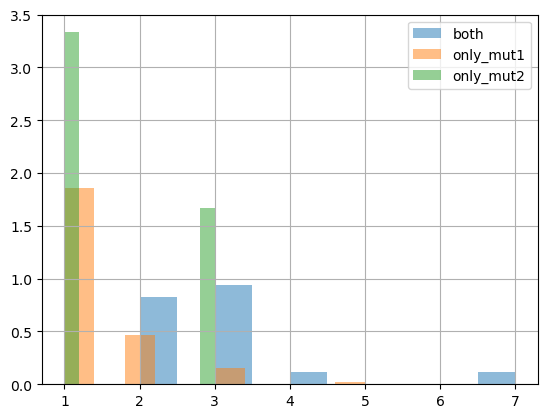

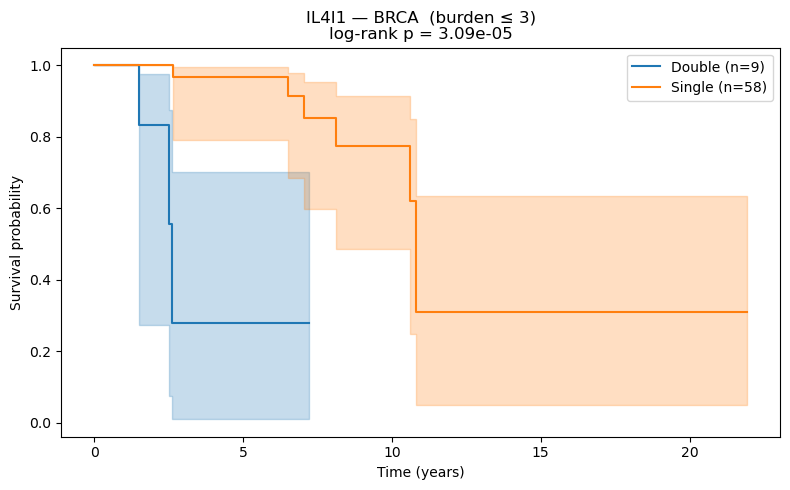

3.090186360626854e-05


In [57]:
mut_id = 'IL4I1:19:49896093:T:G|IL4I1:19:49896094:C:G'
epistasis_burden(mut_id).groupby('group').n_mutations_in_gene.hist(legend=True, density=True, alpha=0.5)
print(epistasis_projects(mut_id))
print(epistasis_survival_plot(mut_id, 'BRCA', 3))



In [60]:
surv_df[surv_df.anchor_gene == 'KRAS']




,epistasis_id,anchor_gene,dependent_gene,cond_prob_dep,project,n_double,n_single,p_value,median_surv_double,median_surv_single,double_worse,prog_unfav_p,prog_fav_p,p_fdr,p_bonf,sig_fdr


<Axes: >

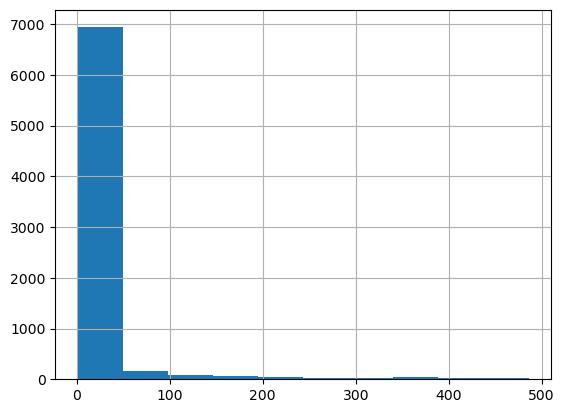

In [62]:
epi_df.distance_bp.hist()



In [82]:
epi_df



,epistasis_id,anchor_mut,dependent_mut,anchor_gene,dependent_gene,distance_bp,n_cases_both,n_only_anchor,n_only_dependent,n_anchor_total,n_dependent_total,cond_prob_dependent,cond_prob_anchor,case_ids_both,case_ids_only_mut1,case_ids_only_mut2
0,AK7:14:96405000:C:T|AK7:14:96405001:C:T,AK7:14:96405000:C:T,AK7:14:96405001:C:T,AK7,AK7,1,50,0,0,50,50,1.0,1.000000,"03da7a65-fa2f-42cb-a709-5fe8736f21d3,0b283f95-...",,
1,PARP4:13:24443452:T:C|PARP4:13:24443453:C:T,PARP4:13:24443453:C:T,PARP4:13:24443452:T:C,PARP4,PARP4,1,50,1,0,51,50,1.0,0.980392,"00eaaf62-c43e-4555-9134-1e5593386fdb,03fa3310-...",,bd1c3d3b-d174-4186-bb35-364e167a1d18
2,C6orf15:6:31111297:C:T|C6orf15:6:31111299:G:A,C6orf15:6:31111297:C:T,C6orf15:6:31111299:G:A,C6orf15,C6orf15,2,49,0,0,49,49,1.0,1.000000,"075d17f2-dd1a-4c12-9e6c-ded1b052d107,0906ddde-...",,
3,FANCD2:3:10046759:C:A|FANCD2:3:10046760:A:G,FANCD2:3:10046759:C:A,FANCD2:3:10046760:A:G,FANCD2,FANCD2,1,49,1,0,50,49,1.0,0.980000,"0cb0dac8-4ce2-444a-b1ae-1550e065b4d9,12c27db5-...",60778da8-d99e-4e51-96a2-3e900b3978d9,
4,GCC2:2:108450881:C:-|GCC2:2:108450882:A:T,GCC2:2:108450881:C:-,GCC2:2:108450882:A:T,GCC2,GCC2,1,49,4,0,53,49,1.0,0.924528,"077bdc90-1bbd-49ec-93a5-729b1ac1ba8d,07d1aef3-...","32398808-c46a-41bf-a0a8-e08723b40ea2,41dcafa0-...",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10895,ZNF66:19:20807174:C:T|ZNF66:19:20807177:G:C,ZNF66:19:20807177:G:C,ZNF66:19:20807174:C:T,ZNF66,ZNF66,3,4,8,1,12,5,0.8,0.333333,"4efebe0b-ea06-4189-be34-5c191f69d1f6,60df8616-...",4bec3959-d59d-4e80-855c-f044a5780780,"0a229f95-0ea1-4d63-953e-74f5ec2f3028,38a8b734-..."
10896,ZNF780A:19:40089374:C:G|ZNF780A:19:40089383:G:T,ZNF780A:19:40089383:G:T,ZNF780A:19:40089374:C:G,ZNF780A,ZNF780A,9,4,2,1,6,5,0.8,0.666667,"72e486b8-a866-4916-b2e4-8b4bb5dcd92d,905291b0-...",1ad7f17e-b3b8-40e9-aab8-5a17e0aec408,"0930e97a-72ea-4bd5-b2f0-50c76af695f3,4fed8f7a-..."
10897,ZNF781:19:37669529:T:C|ZNF781:19:37669537:C:A,ZNF781:19:37669529:T:C,ZNF781:19:37669537:C:A,ZNF781,ZNF781,8,4,1,1,5,5,0.8,0.800000,"565d06a1-3640-4274-8fb3-8cad7e578876,602083f0-...",9446e349-71e6-455a-aa8f-53ec96597146,a2338b30-f511-4163-af3b-1e4a40ff00e1
10898,ZNF99:19:22757857:C:T|ZNF99:19:22757892:C:T,ZNF99:19:22757857:C:T,ZNF99:19:22757892:C:T,ZNF99,ZNF99,35,4,6,1,10,5,0.8,0.400000,"09c4ea05-928d-49b7-b7fb-30cff3481b14,72e486b8-...","37d5c1d9-3ff5-44fe-afdc-ff430a0f3510,452a54f2-...",9f6be944-83de-42ab-8738-f0022f475e61


In [85]:
DATA_DIR = Path('/Users/nicolaslynn/Documents/phd/projects/genomenet/manuscript_figures/input_data/')
import pickle, io, sys, warnings
from pathlib import Path

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", 40)

# -- Helpers ---------------------------------------------------------------
class NumpyCompatUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module.startswith("numpy._core"):
            module = module.replace("numpy._core", "numpy.core", 1)
        return super().find_class(module, name)


# -- Load epistasis predictions --------------------------------------------
with open(DATA_DIR / "tcga_mutations_annotated-2.pkl", "rb") as f:
    tcga_annotated = NumpyCompatUnpickler(f).load()


    

/var/folders/g3/r2czx_11725btzm71z9d0qb40000gn/T/ipykernel_28006/3662244296.py:16: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return super().find_class(module, name)


In [ ]:
tcga_an = tcga_annotated["ConvNova"].epistasis_id.unique().tolist()
tcga_an = ['|'.join([':'.join(p.split('|')[0].split(':')[:-1]), ':'.join(p.split('|')[1].split(':')[:-1])]) for p in tcga_an]
tcga_an


In [98]:
epi_df[epi_df.epistasis_id.isin(tcga_an)]



,epistasis_id,anchor_mut,dependent_mut,anchor_gene,dependent_gene,distance_bp,n_cases_both,n_only_anchor,n_only_dependent,n_anchor_total,n_dependent_total,cond_prob_dependent,cond_prob_anchor,case_ids_both,case_ids_only_mut1,case_ids_only_mut2
7,SETD2:3:47039701:-:CT|SETD2:3:47039704:GA:-,SETD2:3:47039701:-:CT,SETD2:3:47039704:GA:-,SETD2,SETD2,3,49,0,0,49,49,1.0,1.000000,"016caf42-4e19-4444-ab5d-6cf1e76c4afa,01ed791e-...",,
15,SETD2:3:47039701:-:CT|SETD2:3:47039707:A:G,SETD2:3:47039701:-:CT,SETD2:3:47039707:A:G,SETD2,SETD2,6,48,1,0,49,48,1.0,0.979592,"016caf42-4e19-4444-ab5d-6cf1e76c4afa,01ed791e-...",0ce940f2-9eb1-4757-8f8f-147a4f3a1e67,
16,SETD2:3:47039704:GA:-|SETD2:3:47039707:A:G,SETD2:3:47039704:GA:-,SETD2:3:47039707:A:G,SETD2,SETD2,3,48,1,0,49,48,1.0,0.979592,"016caf42-4e19-4444-ab5d-6cf1e76c4afa,01ed791e-...",0ce940f2-9eb1-4757-8f8f-147a4f3a1e67,
78,CFAP46:10:132922205:T:A|CFAP46:10:132922207:T:A,CFAP46:10:132922205:T:A,CFAP46:10:132922207:T:A,CFAP46,CFAP46,2,41,0,0,41,41,1.0,1.000000,"04a1f2dc-1b1a-4328-b35d-cdc1b99e7b5b,0ac27bc8-...",,
289,HLA-DRB5:6:32530071:-:TTT|HLA-DRB5:6:32530072:-:G,HLA-DRB5:6:32530072:-:G,HLA-DRB5:6:32530071:-:TTT,HLA-DRB5,HLA-DRB5,1,30,1,0,31,30,1.0,0.967742,"03f3dd32-e1d1-485b-a968-3f55798f4d46,056386db-...",,49d8939c-7c23-4a6c-b71a-0c39c262c346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10866,UBC:12:124913727:G:A|UBC:12:124913742:A:G,UBC:12:124913727:G:A,UBC:12:124913742:A:G,UBC,UBC,15,4,2,1,6,5,0.8,0.666667,"13d12179-3182-4f41-85a2-90fd50e51480,390eed6b-...","159e0318-6173-440f-be07-8d956086e99d,1b6c184a-...",764c97c9-01d3-45cb-86bd-f8a52b5468da
10867,UBC:12:124913727:G:A|UBC:12:124913748:C:G,UBC:12:124913727:G:A,UBC:12:124913748:C:G,UBC,UBC,21,4,2,1,6,5,0.8,0.666667,"13d12179-3182-4f41-85a2-90fd50e51480,390eed6b-...","159e0318-6173-440f-be07-8d956086e99d,1b6c184a-...",764c97c9-01d3-45cb-86bd-f8a52b5468da
10883,ZFP62:5:180848984:C:T|ZFP62:5:180848988:C:T,ZFP62:5:180848984:C:T,ZFP62:5:180848988:C:T,ZFP62,ZFP62,4,4,259,1,263,5,0.8,0.015209,"045c13ef-3db7-4adf-b0a3-23338f0479f3,4ac693e9-...","001e0309-9c50-42b0-9e38-347883ee2cd3,01674b2c-...",ccd4a24b-d8cc-4686-9dee-c98b0c5a8d21
10887,ZNF335:20:45949914:A:C|ZNF335:20:45949920:A:C,ZNF335:20:45949920:A:C,ZNF335:20:45949914:A:C,ZNF335,ZNF335,6,4,11,1,15,5,0.8,0.266667,"a8b1f6e7-2bcf-460d-b1c6-1792a9801119,b3df9c0a-...",3c5e7a3f-29b3-4af4-9023-dc7b151f0445,"027b2a29-2fad-4ca8-a7cd-eb913d0205f8,054f472f-..."
